# PyTorch and fastai implementations of RMSProp

In [1]:
from fastai2.vision.all import *
from fastai2.callback.fp16 import *

## Data

In [2]:
path = untar_data(URLs.IMAGENETTE)
Path.BASE_PATH = path
path.ls()

(#2) [Path('val'),Path('train')]

In [3]:
(path/'train').ls()

(#10) [Path('train/n03028079'),Path('train/n02102040'),Path('train/n03000684'),Path('train/n01440764'),Path('train/n03888257'),Path('train/n03425413'),Path('train/n02979186'),Path('train/n03394916'),Path('train/n03417042'),Path('train/n03445777')]

In [4]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=GrandparentSplitter(valid_name='val'),
    item_tfms=Resize(460),
    batch_tfms=[*aug_transforms(size=224, min_scale=0.75),
                Normalize.from_stats(*imagenet_stats)])

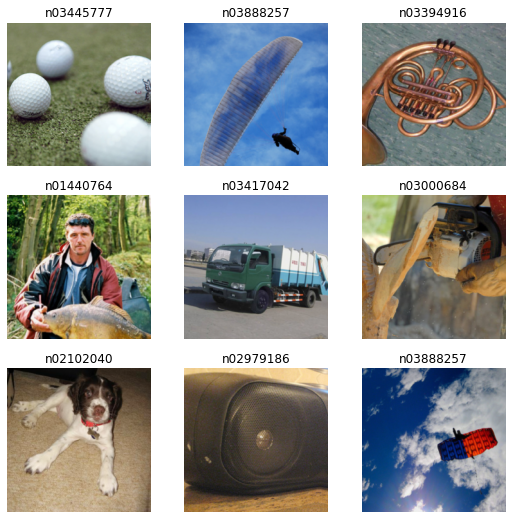

In [5]:
dls = dblock.dataloaders(path)
dls.show_batch()

### Model

In [27]:
model = xresnet50(n_out=dls.c)

## fastai implementation using optimizer callbacks

In [28]:
def second_moment(p, beta2, sq_avg=None, **kwargs):
    if sq_avg is None: sq_avg = torch.zeros_like(p.grad.data)
    return {'sq_avg': beta2*sq_avg + (1-beta2)*(p.grad.data**2)}

In [29]:
def rmsprop_step(p, lr, eps, sq_avg, **kwargs):
    denom = sq_avg.sqrt().add_(eps)
    p.data.addcdiv_(-lr, p.grad.data, denom)

In [30]:
opt_func = partial(Optimizer, cbs=[second_moment, rmsprop_step],
                   beta2=0.99, eps=1e-7)

### create and train learner

In [31]:
learn = Learner(dls, model, opt_func=opt_func, metrics=accuracy).to_fp16()

SuggestedLRs(lr_min=0.04365158379077912, lr_steep=0.3630780577659607)

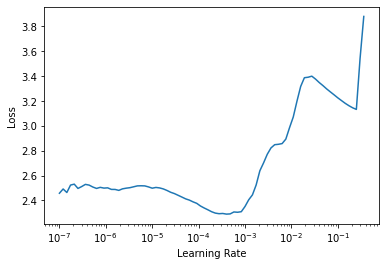

In [32]:
learn.lr_find()

In [33]:
lr=1e-4


In [34]:
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,accuracy,time
0,1.708687,1.554577,0.498854,01:29
1,1.383866,1.279662,0.610955,01:28
2,1.213264,1.190497,0.636943,01:28
3,1.148178,1.133952,0.646879,01:28
4,1.098932,1.120234,0.659618,01:30


## PyTorch implementation